$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 1: Linear Regression

Zach Goodenow<br>
zachgood@rams.colostate.edu<br>
CS 445<br>
1/31/18<br>

## Overview

The objective of this assignment is to use a large data set with multiple input variables to predict their associated target variables.  This can be accomplished by creating a linear model that associates weights with each variable along with a bias.  After the weights are trained and the model is made, the accuracy of the model can be measured by the root-mean-squared error (RMSE).  A model that models the target variables more accurately will have a smaller RMSE, hence, the objective is to minimize the root-mean-squared error.

## Method

The following functions are used:

  * ```model = train(X, T)```
  * ```predict = use(model, X)```
  * ```error = rmse(predict, T)```
  
Let ```X``` be a two-dimensional matrix (```np.array```) with each row containing one data sample, and ```T``` be a two-dimensional matrix of one column containing the target values for each sample in ```X```.  So, ```X.shape[0]``` is equal to ```T.shape[0]```.   

Function ```train``` must standardize the input data in ```X``` and return a dictionary with  keys named ```means```, ```stds```, and ```w```.  

Function ```use``` must also standardize its input data X by using the means and standard deviations in the dictionary returned by ```train```.

Function ```rmse``` returns the square root of the mean of the squared error between ```predict``` and ```T```.

Also:

   * ```model = trainSGD(X, T, learningRate, numberOfIterations)```

which performs the incremental training process described in class as stochastic gradient descent (SGC).  The result of this function is a dictionary with the same keys as the dictionary returned by the above ```train``` function.

The goal of the `train` function is to provide weights for each variable (including the bias) that provide the most accurate prediction for the target variable(s) across all samples.  The equation for applying the weights to the variables looks like this,

$$
    g(\xv;\wv) = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_D x_D = \xv^T \wv
$$

with which can be derive the equation,

$$
\begin{align*}
\wv_{\mbox{best}} &= \argmin{\wv} \sum_{n=1}^N (t_n - g(\xv_n ; \wv))^2\\
 \end{align*}
$$

Now, to solve this equation, take the derivative with respect to $\wv$, set it equal to 0 and solve for $\wv$. To make this process easier, we can break the derivative down to a matrix equation before we set equal to 0 and solve for $\wv$.  Here is that equation,

$$
\begin{align*}
\frac{\partial \sum_{n=1}^N (\tv_n - g(\xv_n;\wv))^2}{\partial \wv} 
&= -2 \sum_{n=1}^N (\tv_n - \xv_n^T \wv) \xv_n^T\\
&= -2 \Xv^T (\Tv - \Xv \wv)
\end{align*}
$$

$$
\begin{align*}
-2 \Xv^T (\Tv - \Xv \wv) &= 0\\
\Xv^T (\Tv - \Xv \wv) &= 0\\
\Xv^T \Tv &= \Xv^T \Xv \wv\\
\wv &= (\Xv^T \Xv)^{-1} \Xv^T \Tv
\end{align*}
$$

I solve this equation in python with this line of code from my `train` function

    'w': np.linalg.lstsq(Xs1.T @ Xs1, Xs1.T @ T)[0]

Another way to create a model is through Sample-by-Sample Linear Regression, also referred to as sequential, on-line, or stochastic gradient descent (SGD), training.  The advantage of SGD training is that it avoids matrix operations that can be very expensive when dealing with large data sets.  This is done by iterating through each sample and updating each $\wv$ based on the derivative of the square error for that sample.  The equation for this process is given as

$$
\begin{align*}
\wv^{(k+1)} &= \wv^{(k)} - (-2) \eta (t_n - \xv_n^T  \wv) \xv_n\\
 &= \wv^{(k)} + \eta (t_n - \xv_n^T  \wv) \xv_n
\end{align*}
$$

The `trainSGD` function uses this process to train the weights and create a linear model.

In [2]:
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def standardize(X):
    return (X - X.mean(0)) / X.std(0)


def train(X, T):
    # Check that X.shape[0] is equal to T.shape[0] i.e. number of rows is equal
    if X.shape[0] != T.shape[0]:
        raise ValueError('X and T have different shapes. X = {} & T = {}'.format(X.shape[0], T.shape[0]))

    # Standardize and add a column of 1s
    Xs1 = np.insert(standardize(X), 0, 1, 1)

    return {'means': X.mean(0), 'stds': X.std(0), 'w': np.linalg.lstsq(Xs1.T @ Xs1, Xs1.T @ T)[0]}


def use(model, X):
    return np.insert(standardize(X), 0, 1, 1) @ model.get('w')


def rmse(predict, T):
    return np.sqrt(np.mean((predict - T)**2))


def trainSGD(X, T, learningRate, numberOfIterations):
    # Check that X.shape[0] is equal to T.shape[0] i.e. number of rows is equal
    if X.shape[0] != T.shape[0]:
        raise ValueError('X and T have different shapes. X = {} & T = {}'.format(X.shape[0], T.shape[0]))

    # Standardize and add a column of 1s
    Xs1 = np.insert(standardize(X), 0, 1, 1)

    # Make weight array of 0s
    w = np.zeros((Xs1.shape[1], T.shape[1]))

    for iter in range(numberOfIterations):
        for n in range(Xs1.shape[0]):
            predicted = Xs1[n:n+1, :] @ w  # n:n+1 is used instead of n to preserve the 2-dimensional matrix structure
            # Update w using derivative of error for nth sample
            w += learningRate * Xs1[n:n+1, :].T * (T[n:n+1, :] - predicted)

    return {'means': X.mean(0), 'stds': X.std(0), 'w': w}

## Example

In [5]:
# Mock data
X = np.arange(10).reshape((5, 2))
T = np.array([[  1.0106937 ],[  8.27898519],[ 14.14662076],[ 19.7094467 ],[ 26.89608484]])
print('Inputs')
print(X)
print('Targets')
print(T)

Inputs
[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
Targets
[[  1.0106937 ]
 [  8.27898519]
 [ 14.14662076]
 [ 19.7094467 ]
 [ 26.89608484]]


In [9]:
# Full linear model
model = train(X, T)
model

{'means': array([ 4.,  5.]),
 'stds': array([ 2.82842712,  2.82842712]),
 'w': array([[ 14.00836624],
        [  4.46900281],
        [  4.46900281]])}

In [10]:
predicted = use(model, X)
predicted

array([[  1.36811748],
       [  7.68824186],
       [ 14.00836624],
       [ 20.32849062],
       [ 26.648615  ]])

In [11]:
rmse(predicted, T)

0.43365895571243512

In [12]:
# Train a model using stochastic gradient descent
modelSGD = trainSGD(X, T, 0.01, 100) # learning rate = 0.01, and trained 100 times
modelSGD

{'means': array([ 4.,  5.]),
 'stds': array([ 2.82842712,  2.82842712]),
 'w': array([[ 13.9239702 ],
        [  4.46992313],
        [  4.46992313]])}

In [13]:
predicted = use(modelSGD, X)
predicted

array([[  1.28111838],
       [  7.60254429],
       [ 13.9239702 ],
       [ 20.24539611],
       [ 26.56682203]])

In [14]:
rmse(predicted, T)

0.44179878720061816

## Data

I downloaded ```energydata_complete.csv``` from the [Appliances energy prediction Data Set ](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction) at the UCI Machine Learning Repository. Ignore the first column (date and time), use the next two columns as target variables, and use all but the last two columns (named rv1 and rv2) as input variables. 

In the following code cell, I am loading the data in using the `read_csv` function from pandas by passing the url of the energy data.  I preview the first 5 rows as a first step to visualize the data I am working with.  **The raw data has 19735 rows and 29 columns.** Hence, there are 19735 samples that include 29 variables.  The first variable is *date* but we will be ignoring that.  The next 2 variables are considered the target variables, which are *Appliances* and *Lights*.  The next variables are input variables but they do not have very descriptive names.  However, the repository has a description of what the data is and what each variable represents:

</div> <div class="alert alert-block alert-warning">
"The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters). "
</div>

  * date time year-month-day hour:minute:second 
  * Appliances, energy use in Wh 
  * lights, energy use of light fixtures in the house in Wh 
  * T1, Temperature in kitchen area, in Celsius 
  * RH_1, Humidity in kitchen area, in % 
  * T2, Temperature in living room area, in Celsius 
  * RH_2, Humidity in living room area, in % 
  * T3, Temperature in laundry room area 
  * RH_3, Humidity in laundry room area, in % 
  * T4, Temperature in office room, in Celsius 
  * RH_4, Humidity in office room, in % 
  * T5, Temperature in bathroom, in Celsius 
  * RH_5, Humidity in bathroom, in % 
  * T6, Temperature outside the building (north side), in Celsius 
  * RH_6, Humidity outside the building (north side), in % 
  * T7, Temperature in ironing room , in Celsius 
  * RH_7, Humidity in ironing room, in % 
  * T8, Temperature in teenager room 2, in Celsius 
  * RH_8, Humidity in teenager room 2, in % 
  * T9, Temperature in parents room, in Celsius 
  * RH_9, Humidity in parents room, in % 
  * To, Temperature outside (from Chievres weather station), in Celsius 
  * Pressure (from Chievres weather station), in mm Hg 
  * RH_out, Humidity outside (from Chievres weather station), in % 
  * Wind speed (from Chievres weather station), in m/s 
  * Visibility (from Chievres weather station), in km 
  * Tdewpoint (from Chievres weather station), Â°C 
  * rv1, Random variable 1, nondimensional 
  * rv2, Random variable 2, nondimensional 

In [15]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv"
edat = pd.read_csv(url)
print(edat.shape)
edat[:5]

(19735, 29)


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


To further visualize the data, I make a box plot of each variable to show the distribution of data based on the five number summary: minimum, first quartile, median, third quartile, and maximum.  This could be helpful for identifying outliers or any variables that are distributed in specific ways.

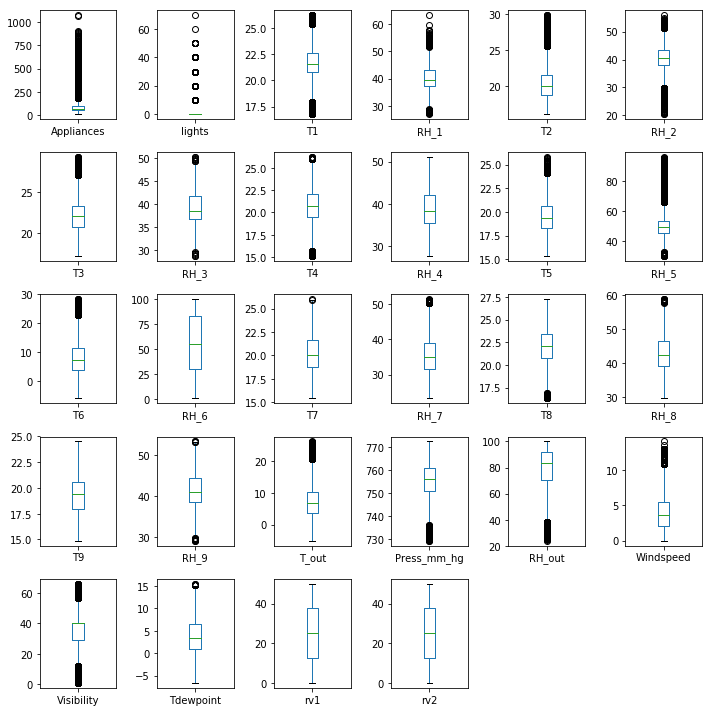

In [16]:
edat.plot(kind='box', subplots=True, layout=(5,6), sharex=False, sharey=False, figsize=(10, 10))
plt.tight_layout()
plt.show()

Since we want to ignore the first column and last 2 columns, I pass an array with values 1-26 to *usecols*.  I pass None to *header* so that the array will include the column names.  I do this so I can make an array for the names.  This matrix should have an additional row and 3 fewer columns than the previous cell.  The first row of the np array will be the names of each variable.  I slice the data into target names, target values, X names, and X values. I also specify that the data is of type np.float because the data was loaded in as strings.

In [17]:
edata = np.array(pd.read_csv(url, usecols = range(1, 27), header = None))
edata.shape

(19736, 26)

In [18]:
names_T = edata[0, :2]
edata_T = edata[1:, :2].astype(np.float)
names_X = edata[0, 2:]
edata_X = edata[1:, 2:].astype(np.float)
edata_T.shape, edata_X.shape

((19735, 2), (19735, 24))

I noticed that the box plots for the target variables looked abnormal so I plotted a density histogram to show the distribution of the values.  The histogram for Appliances shows that most of the values land between 0-200 but the range of the data is between 0-1080.  After taking a closer look at this data, I also noticed it landed on increments of 10.   The histogram for lights shows that the values are discrete, meaning the values are not continuous across the range.  In fact, the data only takes on values of 0, 10, 20, 30, 40, 50, 60, or 70, with a majority of the data at 0, 10, or 20.  This should be kept in mind when modeling and predicting the target variables.

In [19]:
print("Unique values of Appliances: \n", np.unique(edata_T[:,0]))
print("Unique values of Lights: ", np.unique(edata_T[:,1]))

Unique values of Appliances: 
 [   10.    20.    30.    40.    50.    60.    70.    80.    90.   100.
   110.   120.   130.   140.   150.   160.   170.   180.   190.   200.
   210.   220.   230.   240.   250.   260.   270.   280.   290.   300.
   310.   320.   330.   340.   350.   360.   370.   380.   390.   400.
   410.   420.   430.   440.   450.   460.   470.   480.   490.   500.
   510.   520.   530.   540.   550.   560.   570.   580.   590.   600.
   610.   620.   630.   640.   650.   660.   670.   680.   690.   700.
   710.   720.   730.   740.   750.   760.   770.   780.   790.   800.
   820.   830.   840.   850.   860.   870.   880.   890.   900.   910.
  1070.  1080.]
Unique values of Lights:  [  0.  10.  20.  30.  40.  50.  60.  70.]


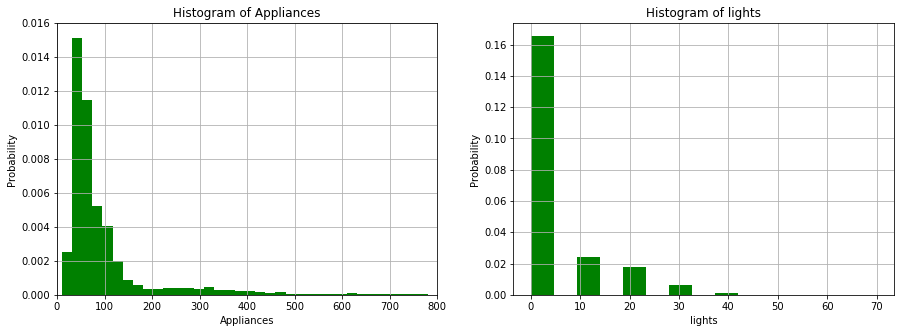

In [20]:
plt.figure(figsize=(15,5))
# Plot for Appliances
plt.subplot(1,2,1)
plt.hist(edata_T[:, 0], 50, normed=True, facecolor='g')
plt.xlabel(names_T[0])
plt.ylabel('Probability')
plt.title('Histogram of ' + names_T[0])
plt.grid(True)
plt.axis([0, 800, 0, 0.016])

# Plot for lights
plt.subplot(1,2,2)
# plt.hist(edata_T[:, 1], bins=np.unique(edata_T[:, 1]), normed=True, facecolor='g')
plt.hist(edata_T[:, 1], bins=15, normed=True, facecolor='g')
plt.xlabel(names_T[1])
plt.ylabel('Probability')
plt.title('Histogram of ' + names_T[1])
plt.grid(True);

To look of a linear correlation between the target variables and all input variables, I made scatter plots.  In these plots I am looking for a pattern that looks like a line.  Plots with high correlation indicate a variable that likely has a strong influence on the target variable.
<br><br>
**Appliances scatter plots**: none of the plots stand out at first glance. All of these plots look like a consistent blob of dots between appliance levels of 0-200.  T8 might have some positive linearity and windspeed might have some negative linearity but it is still hard to tell. 
<br><br>
**Lights scatter plots**: there aren't any plots that stand out at first glance here either.  There might be some linearity with RH_1, RH_2, or RH_out but it is definitely not very strong.  
<br>
These plots don't indicate any obvious linearity but they will still be good to reference after I explore the data further and make models. 

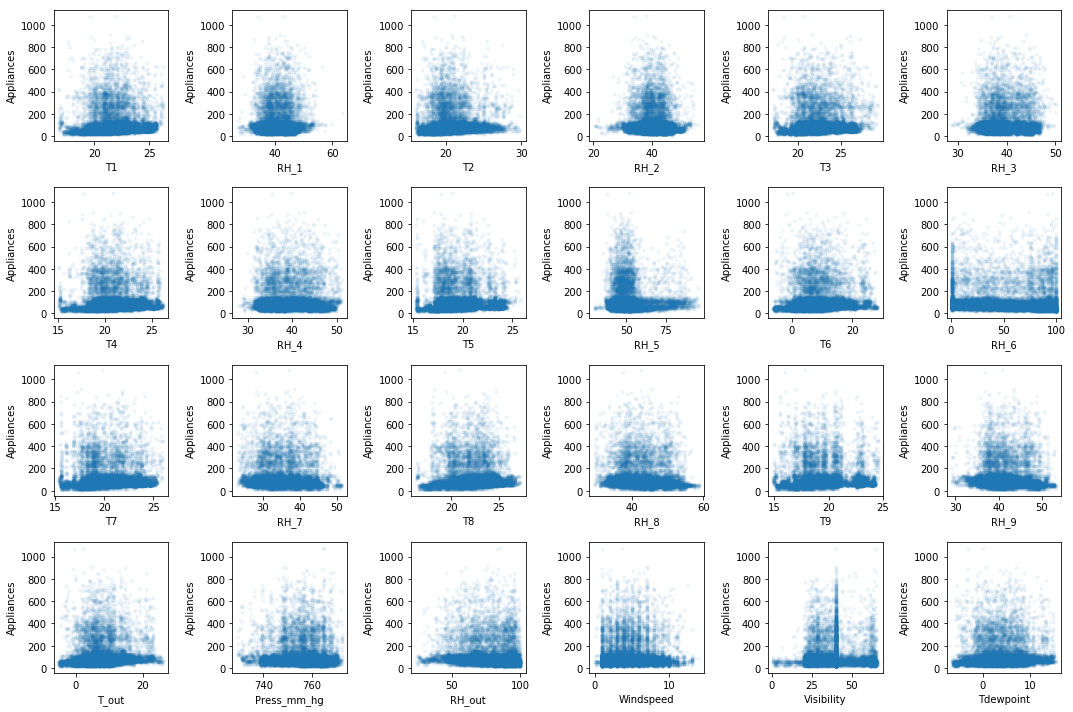

In [80]:
plt.figure(figsize=(15, 10))
for col in range(edata_X.shape[1]):
    plt.subplot(4,6, col+1)
    plt.plot(edata_X[:, col], edata_T[:, :1], '.', alpha=0.05);
    plt.ylabel(names_T[0])
    plt.xlabel(names_X[col])
plt.tight_layout()

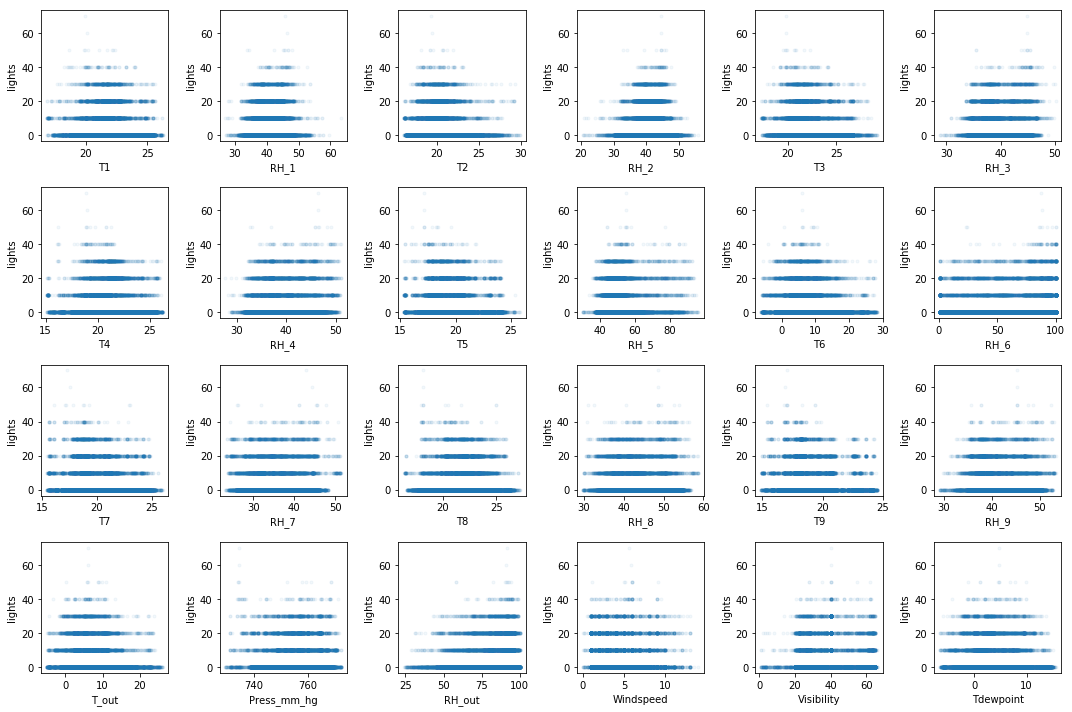

In [81]:
plt.figure(figsize=(15, 10))
for col in range(edata_X.shape[1]):
    plt.subplot(4,6, col+1)
    plt.plot(edata_X[:, col], edata_T[:, 1:], '.', alpha=0.05);
    plt.ylabel(names_T[1])
    plt.xlabel(names_X[col])
plt.tight_layout()

I adjusted the Y axis limit and the transparency of the dots to look closer for signs of linearity.  Still nothing great from this plots which would imply a linear model might not be the best option to analyze this data.  I predict that the models I make will not do a very good job predicting the data.   

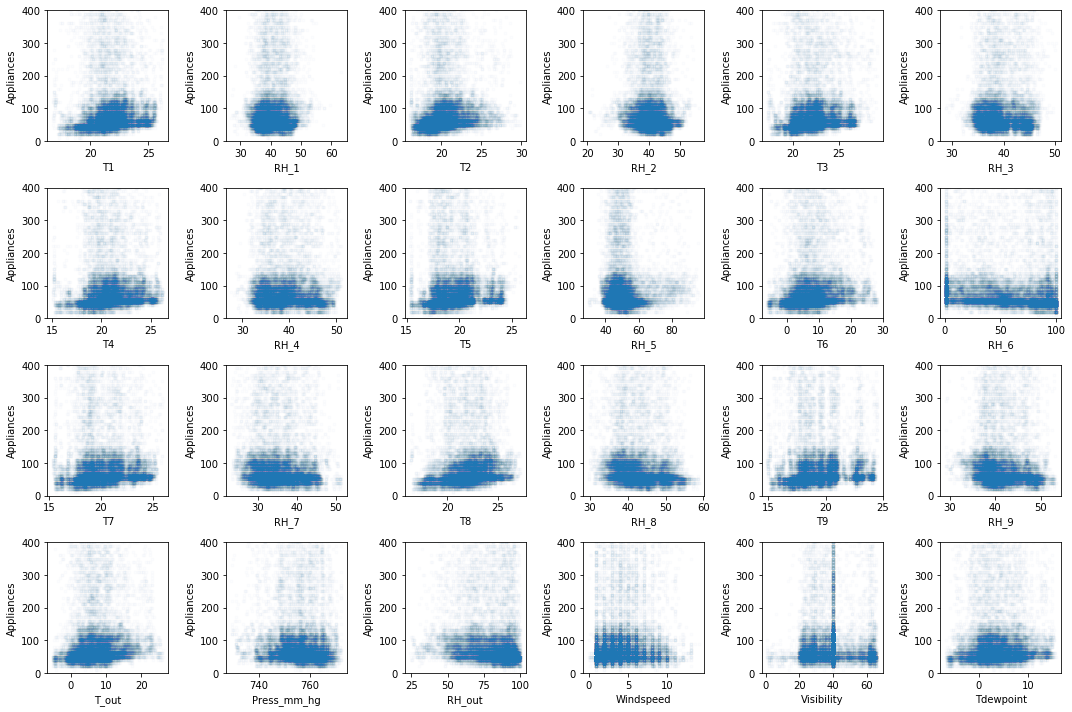

In [23]:
plt.figure(figsize=(15, 10))
for col in range(edata_X.shape[1]):
    plt.subplot(4,6, col+1)
    plt.plot(edata_X[:, col], edata_T[:, :1], '.', alpha=0.01);
    plt.ylim((0,400))
    plt.ylabel(names_T[0])
    plt.xlabel(names_X[col])
plt.tight_layout()

## Results

Apply your functions to the data.  Compare the error you get as a result of both training functions.  Experiment with different learning rates for ```trainSGD``` and discuss the errors.

Make some plots of the predicted energy uses and the actual energy uses versus the sample index.  Also plot predicted energy use versus actual energy use.  Show the above plots for the appliances energy use and repeat them for the lights energy use. Discuss your observations of each graph.

Show the values of the resulting weights and discuss which ones might be least relevant for fitting your linear model.  Remove them, fit the linear model again, plot the results, and discuss what you see.

### Linear Model Training

In [228]:
# Use train to make a model and predict then calc rmse
model = train(edata_X, edata_T)
predicted = use(model, edata_X)
rmse(predicted, edata_T) # 67.16

67.160009853101315

### Stochastic Gradient Descent Model Training

In [223]:
modelSGD = trainSGD(edata_X, edata_T, 0.01, 100)
predictedSGD = use(modelSGD, edata_X)
rmse(predictedSGD, edata_T) # 177.0780

177.07807978877082

If I were to choose a model to predict the target values, I would choose the linear model trained by the `train` function. This is because it produced a lower RMSE value which indicates that the predictions were more accurate.  If the predictions were exactly right, the RMSE would be 0.

### Plot Predicted vs. Actual

<div class="alert alert-block alert-info">
To visualize the accuracy of the model, I created a function called ** *plotTvP2* ** to plot Target vs Predicted values for both target variables. I plot the target value on the X axis, and the prediction for that sample on the Y axis (also referred to as Cross-Validated Predictions).  If the model were perfect we would see all the points landing on the red dashed line **$X=Y$**.  The further away that a point is from this line shows how off the prediction was.  I also include the RMSE for just that target variable and predictions.  It would be useless to compare the RMSE for appliances to the RMSE for lights because the values for appliances is much large which would likely create an RMSE that is larger.  However, it will be very helpful to compare the RMSE for appliances of one model to the RMSE for appliances to another model and likewise for lights.

In [36]:
def plotTvP2(predicted, T, name = ['Appliances', 'lights'], rmseText = True):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 5))
    
    ax1.scatter(T[:, 0], predicted[:, 0], edgecolors=(0, 0, 0))
    ax1.plot([T[:, 0].min(), T[:, 0].max()], [T[:, 0].min(), T[:, 0].max()], 'r--', lw=2)
    ax1.set_xlabel('Target')
    ax1.set_ylabel('Predicted')
    ax1.set_title('Target vs. Predicted: ' + name[0])
    if rmseText:
        rmseStr = 'RMSE: ' + str(round(rmse(predicted[:, 0], T[:, 0]), 4))
        ax1.text(0.01, 0.95, rmseStr, size='large', color='red', transform=ax1.transAxes)
    
    
    ax2.scatter(T[:, 1], predicted[:, 1], edgecolors=(0, 0, 0))
    ax2.plot([T[:, 1].min(), T[:, 1].max()], [T[:, 1].min(), T[:, 1].max()], 'r--', lw=2)
    ax2.set_xlabel('Target')
    ax2.set_ylabel('Predicted')
    ax2.set_title('Target vs. Predicted: ' + name[1])
    if rmseText:
        rmseStr = 'RMSE: ' + str(round(rmse(predicted[:, 1], T[:, 1]), 4))
        ax2.text(0.01, 0.95, rmseStr, size='large', color='red', transform=ax2.transAxes)
    
    plt.show()

**Linear model**: both of the error plots show that the linear model does not do a very good job predicting appliances or lights.  Predictions get more inaccurate at larger target values.  This model tends to produce predictions that are smaller than the observed value. 
<br><br>
**SGD model**: error plots show that the SGD model is also pretty far off on appliances and lights.  The appliance predictions are much more spread out for SGD than that for the linear model and the RMSE is much larger.  The predictions for lights are also less accurate.

Error plots for linear model


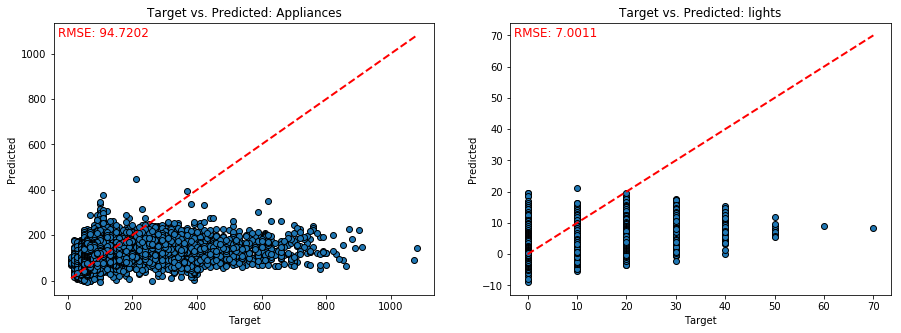

Error plots for SGD model


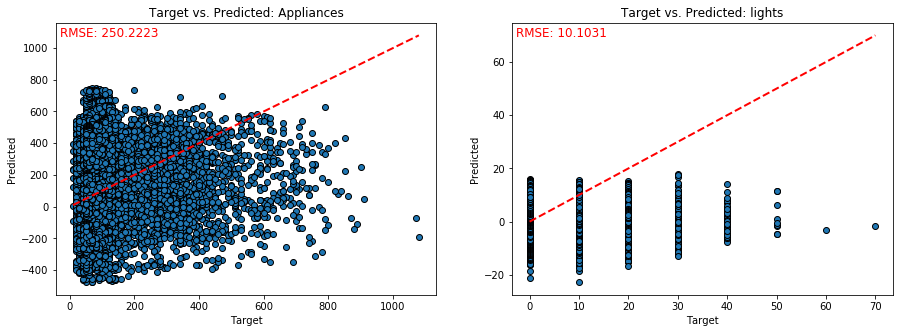

In [226]:
print('Error plots for linear model')
plotTvP2(predicted, edata_T)
print('Error plots for SGD model')
plotTvP2(predictedSGD, edata_T)

### Plot Weights

<div class="alert alert-block alert-info">
To visualize the magnitude of the weights that a model will produce, I created a function called ** *plotWeights* ** to plot the absolute value of each standardized weight.  The reason why I standardize the weight is so I can look at the weights for both target variables relative to each other.  Just like RMSE, the weights for appliances will be larger because it takes on larger values than lights.  The reason why I take the absolute value is to make it easier to see the magnitude of each weight relative to all the other weights.  Hence, weights that are relevant will be large and appear higher up on the Y axis.

In [241]:
def plotWeights(model, Xnames = None, modelName = '', Tnames = ['Appliances', 'lights']):
    if Xnames is None: Xnames = [str(i) for i in range(1,model.get('w').shape[0])]
    plt.figure(figsize=(15, 5))
    plt.plot(abs(standardize(model.get('w')[1:, 0])), '-o', label=Xnames[0])
    plt.plot(abs(standardize(model.get('w')[1:, 1])), '-o', label=Xnames[1])
    plt.xticks(range(len(Xnames)+1), Xnames, rotation=60, horizontalalignment='right')
    plt.ylabel("Abs. Stdzed. Weight")
    plt.xlabel('Variable name')
    plt.title('Absolute value of standardized weights: ' + modelName)
    plt.legend(loc='upper left')
    plt.grid(True);

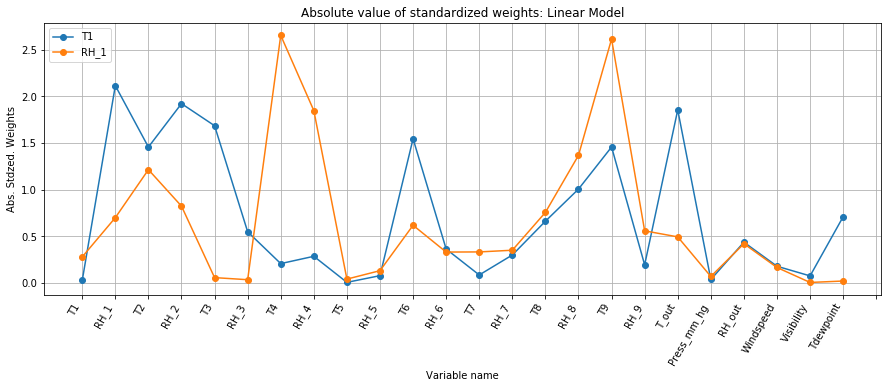

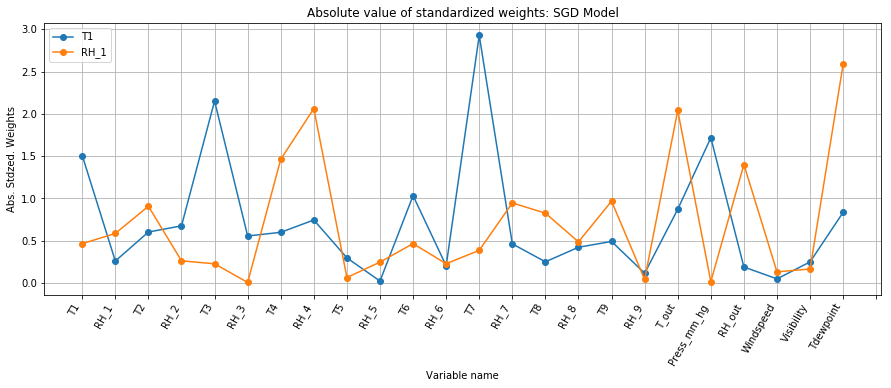

In [246]:
plotWeights(model, names_X, 'Linear Model')
plotWeights(modelSGD, names_X, 'SGD Model')

#### Reduce X and retrain

After plotting the weights for both models, **it looks like the weights for T5, RH_5, RH_6, RH_9, Windspeed, and Visibility are small for both targets in both models**.  These variables could potentially be removed from the model because it is likely that they don't provide any helpful data to train the weights but this is a very objective view.  But it couldn't hurt to try and remove them from $\Xv$ and make new models to see if the RMSE changes. 
<br><br>
The following code removes these variables from the data to make a new $\Xv$ to train new models.  If the RMSE value stays around the same value then I know that those variables might not be necessary to train models.  

In [25]:
# Make list of variable names with small, less relevant weights
vlist = ['T5', 'RH_5', 'RH_6', 'RH_9', 'Windspeed', 'Visibility']
# Get indicies of each of those variables from name_X list
vinds = [names_X.tolist().index(v) for v in vlist]
# Make sure it worked
print(vinds)
print(names_X[vinds])

[8, 9, 11, 17, 21, 22]
['T5' 'RH_5' 'RH_6' 'RH_9' 'Windspeed' 'Visibility']


In [39]:
model_reduced1 = train(edata_X[:, vinds], T)
predicted_reduced1 = use(model_reduced1, edata_X[:, vinds])
print('RMSE for reduced model from train() was ', rmse(predicted_reduced1, T))

RMSE for reduced model from train() was  71.9911960498


In [31]:
# Remove indicies from a list of 0-23 to get relevant indicies
relevant = list(set([i for i in range(24)]) - set(vinds))
relevant

[0, 1, 2, 3, 4, 5, 6, 7, 10, 12, 13, 14, 15, 16, 18, 19, 20, 23]

In [33]:
# Use those variables to make new X matrix
X = edata_X[:, relevant]
T = edata_T

In [34]:
# Use train to make a model and predict then calc rmse for train() and trainSGD()
model_reduced = train(X, T)
predicted_reduced = use(model_reduced, X)
print('RMSE for reduced model from train() was ', rmse(predicted_reduced, T))

modelSGD_reduced = trainSGD(X, T, 0.01, 100)
predictedSGD_reduced = use(modelSGD_reduced, X)
print('RMSE for reduced model from trainSGD() was ', rmse(predictedSGD_reduced, T))

RMSE for reduced model from train() was  67.3164586442
RMSE for reduced model from trainSGD() was  169.195415146


Error plots for reduced linear model


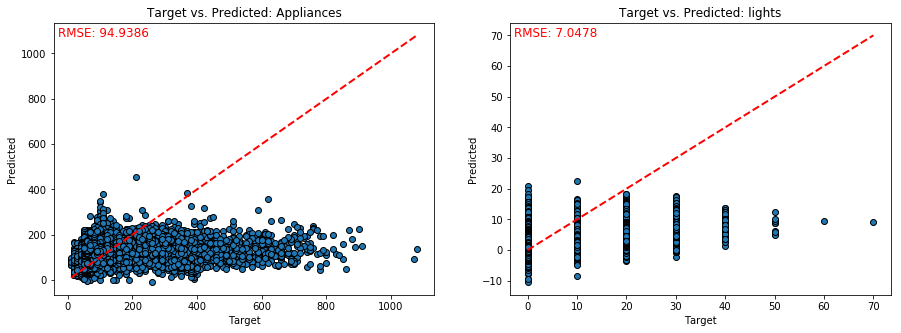

Error plots for reduced SGD model


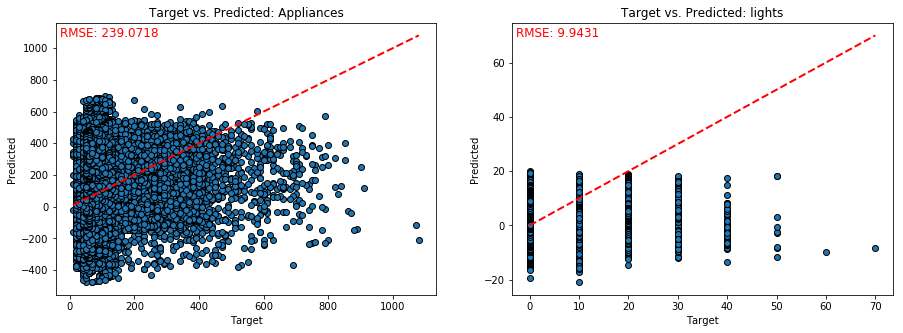

In [37]:
print('Error plots for reduced linear model')
plotTvP2(predicted_reduced, T)
print('Error plots for reduced SGD model')
plotTvP2(predictedSGD_reduced, T)

It looks like the `train()` model was not effected much by the reduction and the SGD model was improved a bit.  Both models are still very inaccurate.  However, I would be comfortable leaving these variables out of the model because they seem to have little influence on the predictions.

#### Train SGD with different learning rate and Iterations

One way to increase the accuracy of the SGD model is to change the learning rate and number of iterations.  Since the RMSE is much higher for the SGD model| I assume that it can be improved with a smaller learning rate and more iterations.  I trained multiple SGD models in my pycharm IDE so I will present the RMSE of those models here:

| Learning Rate | Iterations | RMSE         
| :------------ | :----------- | :-
|0.01           |      100     | 177.0780
|0.001          |    500       | 78.5828
|0.001          |    750  | 78.5828
|0.0005         |   750  | 72.9811
|0.0001         |   750  | 67.6423
|0.00001        |  100  | 67.6546
|0.00001        |   1500| 67.1765
|0.000001       | 100  | 70.2461
|0.000001       | 200  | 68.8372
|0.000001       | 500  | 68.0640
|0.000001       | 1500  | 67.4623
|0.0000001      | 2000  | 68.8357
|0.0000001      | 3000  | 68.4517

The smallest RMSE obtained was 67.1765 with a learning rate of 0.00001 and 1500 iterations.  I will replicate this model below and plot the predictions vs. targets

In [40]:
modelSGD = trainSGD(edata_X, edata_T, 0.00001, 1500)
predictedSGD = use(modelSGD, edata_X)
rmse(predictedSGD, edata_T)

67.176523153211861

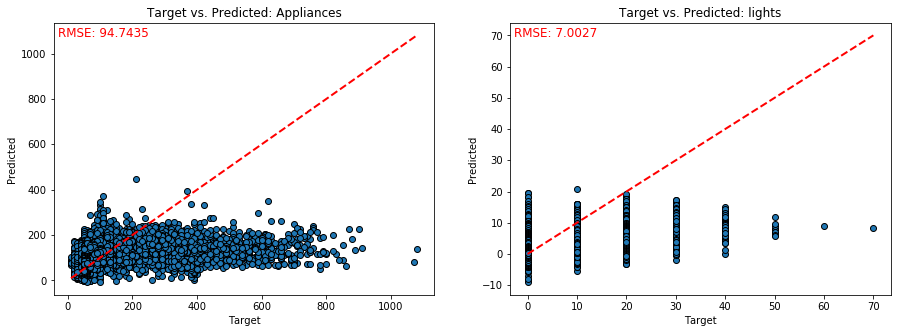

In [41]:
plotTvP2(predictedSGD, edata_T)

Since the RMSE was improved when I removed the variables that had small weights, I will do the same process but on a model that has better training arguments.

In [42]:
X = edata_X[:, relevant]
T = edata_T
modelSGD_RT = trainSGD(X, T, 0.00001, 1500)
predictedSGD_RT = use(modelSGD_RT, X)
rmse(predictedSGD_RT, T)

67.326008917433811

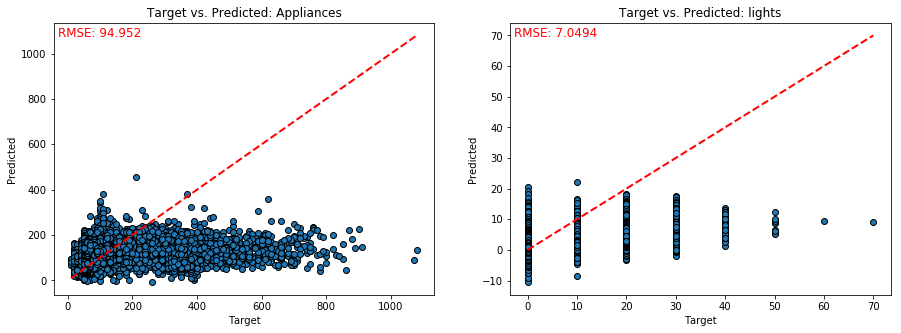

In [43]:
plotTvP2(predictedSGD_RT, T)

Out of curiosity, I decided to make linear models using `train()` with a lot of combinations of input variables.  To do this, I used the `combinations` function from the `itertools` package.  This function takes in a list and the number of elements to chose and returns all unique combinations.  I used these lists to make a linear model for every possible combination of input variables.  I ran the following code cell in pycharm but I will present the results here:

| # of variables  | Lowest RMSE | Variable index list of lowest RMSE         
| :------------   | :----------- | :-
|1   | 71.86708   | [20]
|2   | 70.44970   | [1, 15]
|3   | 69.42004   | [1, 3, 15]
|4   | 68.91982   | [1, 4, 15, 16]
|5   | 68.20394   | [1, 3, 4, 15, 16]
|6   | 67.95376   | [1, 2, 3, 4, 15, 16]
|7   | 67.74211   | [1, 2, 3, 4, 14, 15, 16]
|8   | 67.63799   | [1, 2, 3, 4, 14, 15, 16, 21] ======> DIDNT LET THIS ONE FINISH
|20  | 67.16429   | [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23]
|21  | 67.16157   | [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
|22  | 67.16020   | [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
|23  | 67.16000   | [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
|24  | 67.16000   | [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [264]:
# Example of how to use combinations
from itertools import combinations
 
# Get all combinations of [1, 2, 3]
# and length 2
comb = combinations([1, 2, 3], 2)
 
# Print the obtained combinations
for i in list(comb):
    print(i)

(1, 2)
(1, 3)
(2, 3)


Over all, none of the models I presented do an acceptable job of predicting any of the target variables.  More advanced techniques are required to analyze this data accurately but I wanted to stay focused on what this assignment was looking for.

## Grading

Your notebook will be run and graded automatically.  Test this grading process by first downloading [A1grader.tar](http://www.cs.colostate.edu/~anderson/cs445/notebooks/A1grader.tar) and extract `A1grader.py` from it. Run the code in the following cell (after deleting the one containing A1mysolution) to demonstrate an example grading session.  You should see a perfect execution score of 70/70 if your functions are defined correctly. The remaining 30 points will be based on the results you obtain from the energy data and on your discussions.

A different, but similar, grading script will be used to grade your checked-in notebook.  It will include additional tests.  You need not include code to test that the values passed in to your functions are the correct form.  

In [330]:
%run -i "A1grader.py"


======================= Code Execution =======================

========================RUNNING INSTRUCTORS SOLUTION!
Testing rmse(A, B) with
 A =
[[1 2 3]
 [4 5 6]]
 and B =
[[2 3 4]
 [5 6 7]]

--- 10/10 points. Correctly returned 1.0

Testing model = train(X, T) with
 X=
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [18 20 22]
 [24 26 28]]
 and T=
[[  0.2   1.2]
 [  5.    6. ]
 [ 11.6  12.6]
 [ 62.   64. ]
 [ 96.8  98.8]]

--- 5/5 points. Model correctly includes a key named 'means'.

--- 5/5 points. Model correctly includes a key named 'stds'.

--- 5/5 points. Model correctly includes a key named 'w'.

Testing rmse(T, use(model, X))

--- 15/15 points. Error is correctly calculated as 5.242709223292858.

Testing model = trainSGD(X, T, 0.01, 1000) with
 X=
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [18 20 22]
 [24 26 28]]
 and T=
[[  0.2   1.2]
 [  5.    6. ]
 [ 11.6  12.6]
 [ 62.   64. ]
 [ 96.8  98.8]]

--- 5/5 points. Model correctly includes a key named 'means'.

--- 5/5 points. Model correctly

## Extra Credit

I got some very basic data from Keggle that didn't even have a description of what it was (I think it was artificial data).  It just said it was good to test your linear modeling skills.  First column is T and second is X.  This data set was split into test and train though so I trained the model on the train data set and predicted it on the test data set.  For sake of time I wont interpret the results very much.  I made a new function to plot the predicted vs. target.

In [78]:
def plotTvP1(predicted, T, rmseText = True):
    fig, ax1 = plt.subplots()
    
    ax1.scatter(T, predicted, edgecolors=(0, 0, 0))
    ax1.plot([T.min(), T.max()], [T.min(), T.max()], 'r--', lw=2)
    ax1.set_xlabel('Target')
    ax1.set_ylabel('Predicted')
    ax1.set_title('Target vs. Predicted')
    if rmseText:
        rmseStr = 'RMSE: ' + str(round(rmse(predicted, T), 4))
        ax1.text(0.01, 0.95, rmseStr, size='large', color='red', transform=ax1.transAxes)
    
    plt.show()

In [80]:
kdata_train = pd.read_csv('keggle_train.csv')
kdata_test = pd.read_csv('keggle_test.csv')
print(kdata_train.shape, kdata_test.shape)
kdata_train[:5]

(700, 2) (300, 2)


,x,y
0,24.0,21.549452
1,50.0,47.464463
2,15.0,17.218656
3,38.0,36.586398
4,87.0,87.288984


In [81]:
kdata_test[:5]

,x,y
0,77,79.775152
1,21,23.177279
2,22,25.609262
3,20,17.857388
4,36,41.849864


In [85]:
kdata_train = np.array(kdata_train)
kdata_train = kdata_train[~np.isnan(kdata_train).any(axis=1)] # Remove rows with nans
kdata_test = np.array(kdata_test)
kdata_test = kdata_test[~np.isnan(kdata_test).any(axis=1)] # Remove rows with nans
print(kdata_train.shape, kdata_test.shape)

(699, 2) (300, 2)


In [89]:
train_T = np.array(kdata_train[:, 0:1])
train_X = np.array(kdata_train[:, 1:])
test_T = np.array(kdata_test[:, 0:1])
test_X = np.array(kdata_test[:, 1:])
train_T.shape, train_X.shape, test_T.shape, test_X.shape

((699, 1), (699, 1), (300, 1), (300, 1))

In [90]:
# Use train to make a model and predict then calc rmse
model = train(train_X, train_T)
predicted = use(model, test_X)
rmse(predicted, test_T) # 67.16

3.1477651292449305

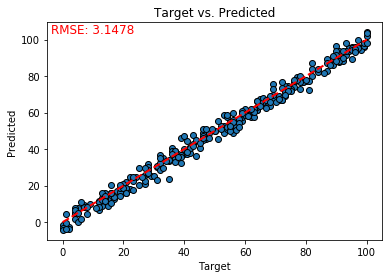

In [91]:
plotTvP1(predicted, test_T)

This plot looks great.  The points are landing very close to the $X=T$ line.  It is cross-validated because the data used to train the model was different than the data used to predict.  
<br>
Now to apply this same process to the SGD train function

In [92]:
modelSGD = trainSGD(train_X, train_T, 0.01, 100)
predictedSGD = use(modelSGD, test_X)
rmse(predictedSGD, test_T) # 177.0780

3.2180715504702935

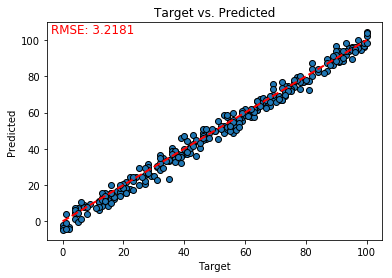

In [94]:
plotTvP1(predictedSGD, test_T)

The RMSE for the SGD is a bit higher than that for the first model but considering how small the learning rate and iterations were I'd say this is a pretty good model.  Much more accurate than the model I made for the actual assignment

I tried to download a second data set and repeat all of the steps.  This data set was player data for FIFA players in the 2018 video game.  I was going to try to predict Player Value, and Player Wage based off of the skill levels of each player.  I ran out of time but I still wanted to present this data.

In [95]:
fifadata = pd.read_csv('FIFA_complete.csv', encoding='utf_8')
fifanames = np.array(list(fifadata.columns.values))
print(fifadata.shape)
fifadata[:5]

(17994, 185)


,ID,name,full_name,club,club_logo,special,age,league,birth_date,height_cm,...,prefers_cb,prefers_lb,prefers_lwb,prefers_ls,prefers_lf,prefers_lam,prefers_lcm,prefers_ldm,prefers_lcb,prefers_gk
0,20801,Cristiano Ronaldo,C. Ronaldo dos Santos Aveiro,Real Madrid CF,https://cdn.sofifa.org/18/teams/243.png,2228,32,Spanish Primera División,1985-02-05,185.0,...,False,False,False,False,False,False,False,False,False,False
1,158023,L. Messi,Lionel Messi,FC Barcelona,https://cdn.sofifa.org/18/teams/241.png,2158,30,Spanish Primera División,1987-06-24,170.0,...,False,False,False,False,False,False,False,False,False,False
2,190871,Neymar,Neymar da Silva Santos Jr.,Paris Saint-Germain,https://cdn.sofifa.org/18/teams/73.png,2100,25,French Ligue 1,1992-02-05,175.0,...,False,False,False,False,False,False,False,False,False,False
3,176580,L. Suárez,Luis Suárez,FC Barcelona,https://cdn.sofifa.org/18/teams/241.png,2291,30,Spanish Primera División,1987-01-24,182.0,...,False,False,False,False,False,False,False,False,False,False
4,167495,M. Neuer,Manuel Neuer,FC Bayern Munich,https://cdn.sofifa.org/18/teams/21.png,1493,31,German Bundesliga,1986-03-27,193.0,...,False,False,False,False,False,False,False,False,False,True


In [96]:
var_names_of_interest = ['age','height_cm','weight_kg','eur_value','eur_wage','overall','potential',
 'pac','sho','pas','dri','def','phy','international_reputation','skill_moves',
 'weak_foot','crossing','finishing','heading_accuracy','short_passing','volleys',
 'dribbling','curve','free_kick_accuracy','long_passing','ball_control','acceleration',
 'sprint_speed','agility','reactions','balance','shot_power','jumping','stamina','strength',
 'long_shots','aggression','interceptions','positioning','vision','penalties','composure','marking',
 'standing_tackle','sliding_tackle','gk_diving','gk_handling','gk_kicking','gk_positioning','gk_reflexes']
var_index = [list(fifanames).index(v) for v in var_names_of_interest]
npfifanames = np.array(fifanames)
npfifanames[var_index]

array(['age', 'height_cm', 'weight_kg', 'eur_value', 'eur_wage', 'overall',
       'potential', 'pac', 'sho', 'pas', 'dri', 'def', 'phy',
       'international_reputation', 'skill_moves', 'weak_foot', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility',
       'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions',
       'positioning', 'vision', 'penalties', 'composure', 'marking',
       'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling',
       'gk_kicking', 'gk_positioning', 'gk_reflexes'], 
      dtype='<U34')

In [97]:
fifadatacut = pd.read_csv('FIFA_complete.csv', encoding='utf_8', usecols = var_index)
fnames = np.array(list(fifadatacut.columns.values))
print(fifadatacut.shape)
fifadatacut[:5]

(17994, 50)


,age,height_cm,weight_kg,eur_value,eur_wage,overall,potential,pac,sho,pas,...,penalties,composure,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,32,185.0,80.0,95500000.0,565000.0,94,94,90,93,82,...,85,95,22,31,23,7,11,15,14,11
1,30,170.0,72.0,105000000.0,565000.0,93,93,89,90,86,...,78,96,13,28,26,6,11,15,14,8
2,25,175.0,68.0,123000000.0,280000.0,92,94,92,84,79,...,81,92,21,24,33,9,9,15,15,11
3,30,182.0,86.0,97000000.0,510000.0,92,92,82,90,79,...,85,83,30,45,38,27,25,31,33,37
4,31,193.0,92.0,61000000.0,230000.0,92,92,91,90,95,...,47,70,10,10,11,91,90,95,91,89
